In [11]:
#Load libraries here
library(tidyverse)
library(repr)

In [12]:
#Read data
tennis_data_raw <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
#tennis_data_raw

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



In [13]:
#Tidying data
names(tennis_data_raw) <- make.names(names(tennis_data_raw), unique = TRUE)
tennis_data_tidy <- tennis_data_raw %>% 
mutate(Last_Appearance = Last.Appearance) %>%
select(-Wikipedia, -X1) %>%
#Separating values
separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
separate(col = Current.Rank, into = c("Current_Rank", "Points_at_Current_Rank"), sep = " ") %>% 
separate(col = Best.Rank, into = c("Best_Rank", "Best_Rank_Date"), sep = " ") %>%
separate(col = Current.Elo.Rank, into = c("Current_Elo_Rank", "Current_Elo_Score"), sep = " ") %>% 
separate(col = Best.Elo.Rank, into = c("Best_Elo_Rank", "Best_Elo_Rank_Date"), sep = " ") %>% 
separate(col = Peak.Elo.Rating, into = c("Peak_Elo_Rating", "Peak_Elo_Rating_Date"), sep = " ") %>% 
separate(col = GOAT.Rank, into = c("GOAT_Rank", "GOAT_Points"), sep = " ") %>%
lapply( function(x) gsub(pattern = "[\\(\\)]",replacement = "", as.character(x))) %>%
data.frame() %>%
#Converting Date format
separate(col = Birthdate, into = c("Birthday","Birthmonth", "Birthyear"), sep = "-") %>% 
separate(col = Best_Rank_Date, into = c("Best_Rank_Day", "Best_Rank_Month", "Best_Rank_Year"), sep = "-") %>%
separate(col = Peak_Elo_Rating_Date, into = c("Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month" ,"Peak_Elo_Rating_Year"), sep = "-") %>%
separate(col = Best_Elo_Rank_Date, into = c("Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year"), sep = "-") %>%
separate(col = Last_Appearance, into = c("Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year"), sep = "-") %>%
#Converting to int
mutate_at(c("Age", "Birthday", "Birthmonth", "Birthyear", "Current_Rank", "Points_at_Current_Rank", "Current_Elo_Rank", "Best_Rank", "Best_Rank_Day", "Current_Elo_Score",
            "Best_Rank_Year", "Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month", "Peak_Elo_Rating_Year", "Peak_Elo_Rating", "Best.Season", "Retired",
            "Best_Elo_Rank", "Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year","Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year", 
            "GOAT_Rank", "GOAT_Points", "Grand.Slams", "Davis.Cups", "Olympics", "Team.Cups", "Turned.Pro", "Seasons", "Titles" ), as.integer) %>%
mutate( Age_at_Best_Rank = Best_Rank_Year - Birthyear)
       

#Removed many vectors for easier viewing of table
tennis_data_filtered <- tennis_data_tidy %>%
                   #Likely irrelevant vectors
                   select(-Facebook, - Twitter, - Nicknames, -Coach, -Web.Site, -Residence, -Birthplace) %>%      
                   #Possibly irrelevant vectors 
                   select(-Davis.Cups, -Team.Cups, -Olympics, - Weight, -Grand.Slams, -Tour.Finals,-Masters, -Weeks.at.No..1, 
                           -Height, -Prize.Money, -Last.Appearance, -Titles, -Active) %>%       
                   #Days and Months
                   select(-Birthday, -Birthmonth, -Best_Rank_Day, -Best_Rank_Month, -Peak_Elo_Rating_Day, -Peak_Elo_Rating_Month,
                          -Best_Elo_Rank_Day, -Best_Elo_Rank_Month, - Last_Appearance_Day, -Last_Appearance_Month) %>% 
                   arrange(Current_Rank)
           
#tennis_data_tidy
#tennis_data_filtered     

In [36]:
tennis_data_tidy$Retired[tennis_data_tidy$Retired > 1990] <- "yes"
tennis_data_tidy$Retired[is.na(tennis_data_tidy$Retired)] <- "no"

#added a few columns, can discuss which to remove
tennis_data <- tennis_data_tidy %>%
                       group_by(Country) %>%
                       summarize(Players_per_Country = n(), Mean_Age = mean(Age, na.rm=TRUE), Mean_Current_Rank = mean(Current_Rank, na.rm = TRUE),
                                 Best_Current_Rank = min(Current_Rank, na.rm = TRUE)) %>%
                       arrange(desc(Players_per_Country))
tennis_data

Warning message in min(Current_Rank, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
`summarise()` ungrouping output (override with `.groups` argument)



Country,Players_per_Country,Mean_Age,Mean_Current_Rank,Best_Current_Rank
<chr>,<int>,<dbl>,<dbl>,<dbl>
France,46,25.39130,252.5435,10
United States,41,25.14634,235.5641,19
Italy,37,26.05405,249.2432,8
Spain,34,27.29412,240.3235,1
Germany,30,27.33333,245.7931,7
Argentina,28,25.25000,255.9286,14
Australia,23,25.17391,213.6087,23
Russian Federation,20,24.90000,289.9500,4
Japan,19,25.47368,259.6842,18


Warning message:
“Removed 5 rows containing missing values (geom_point).”


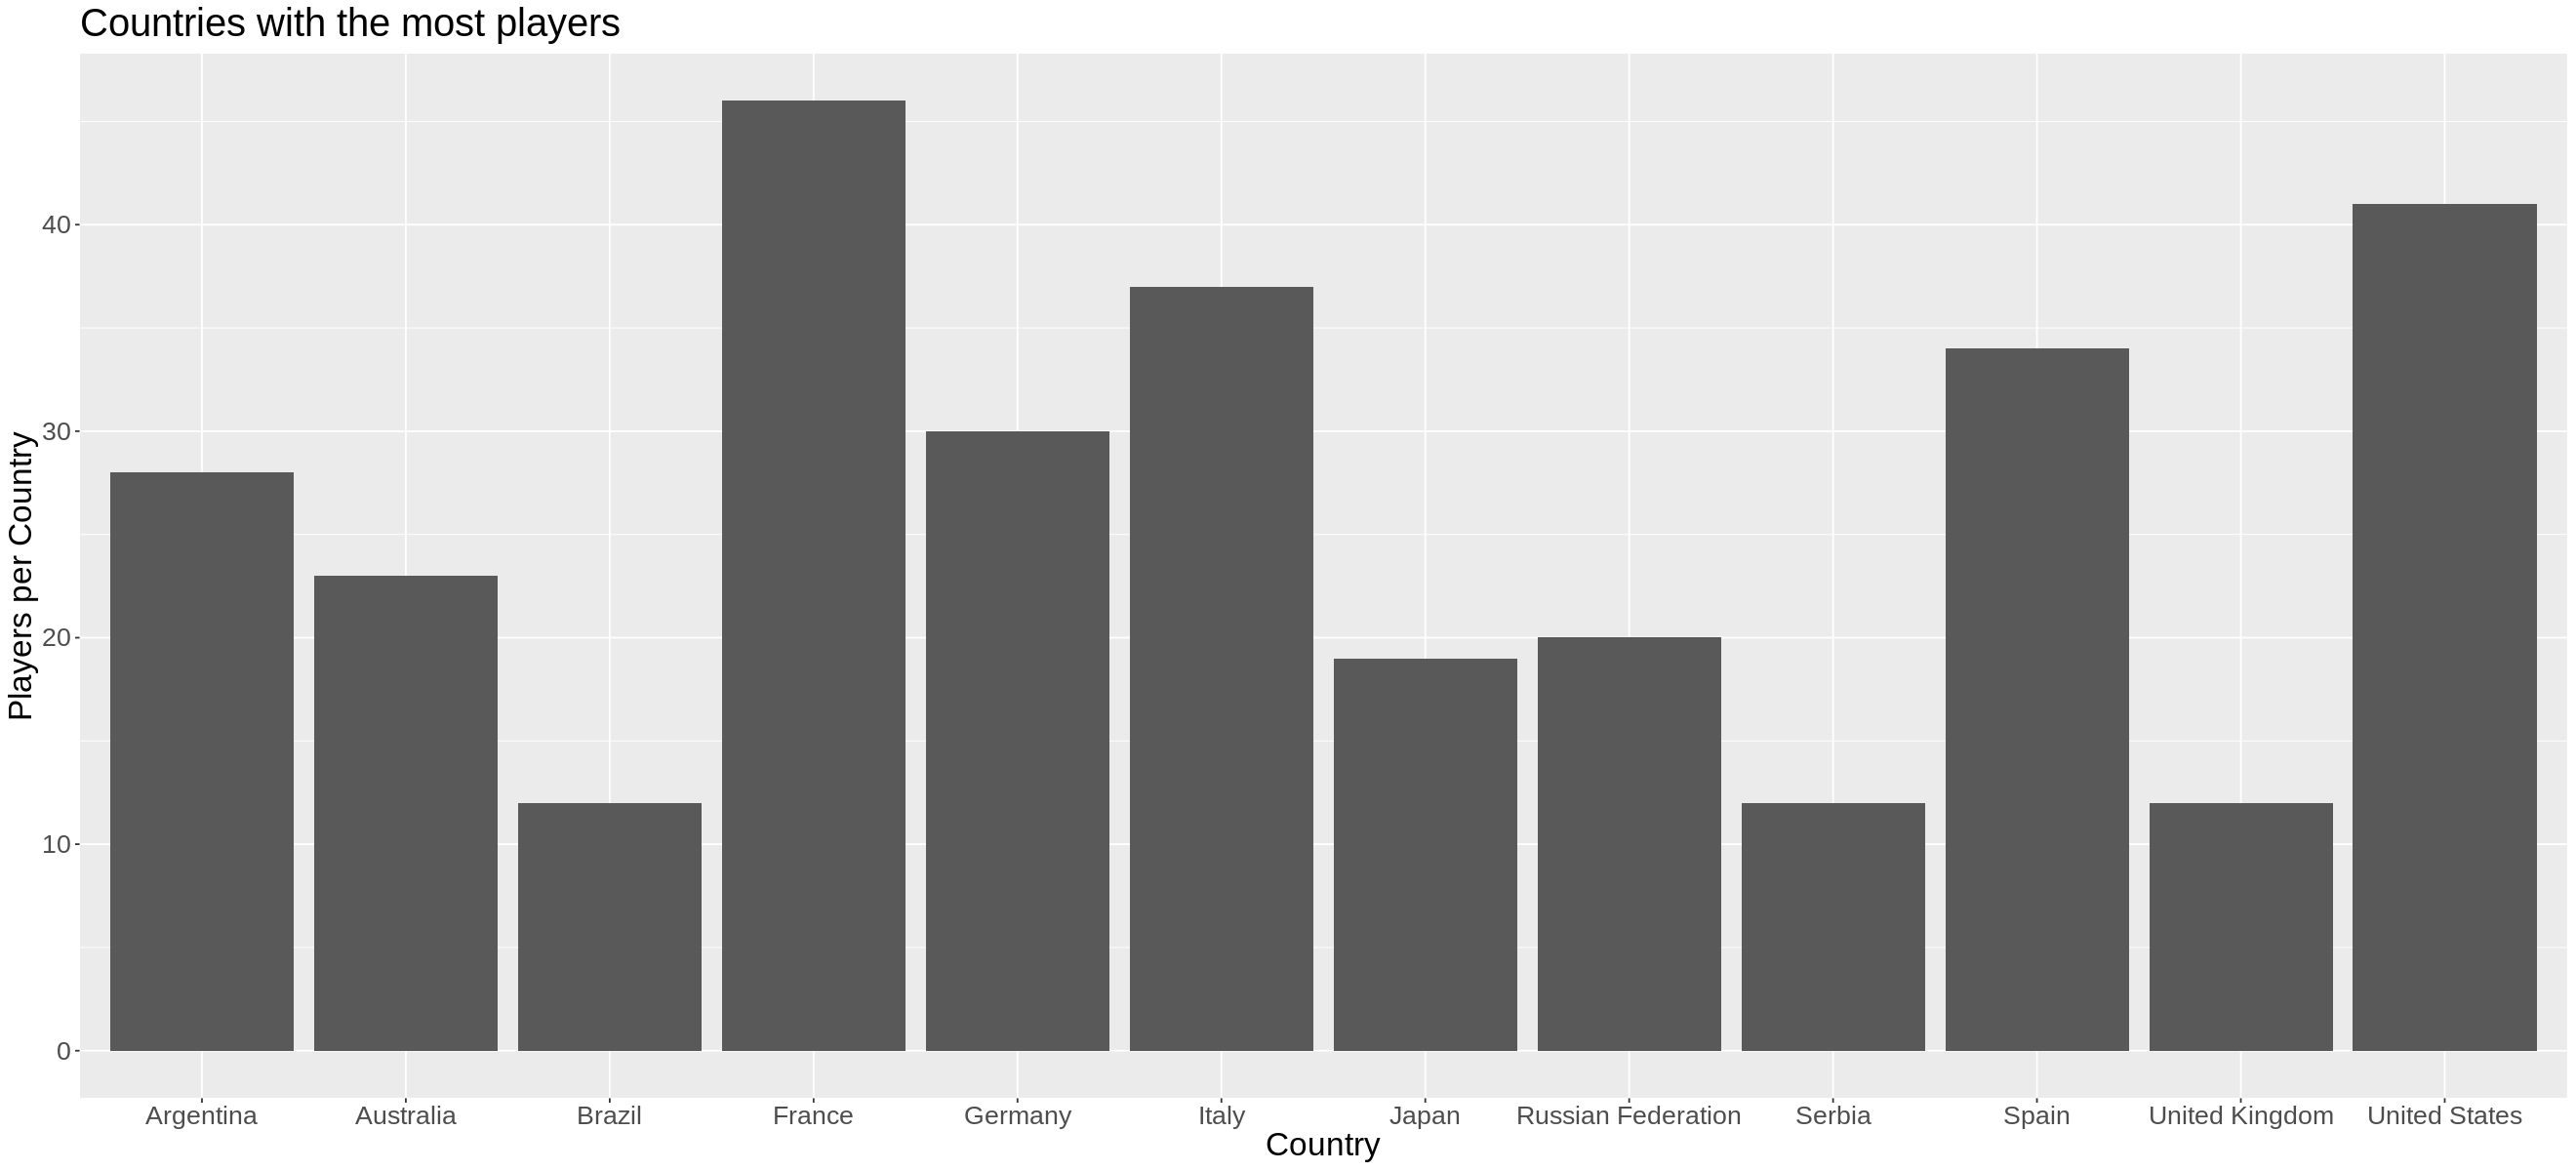

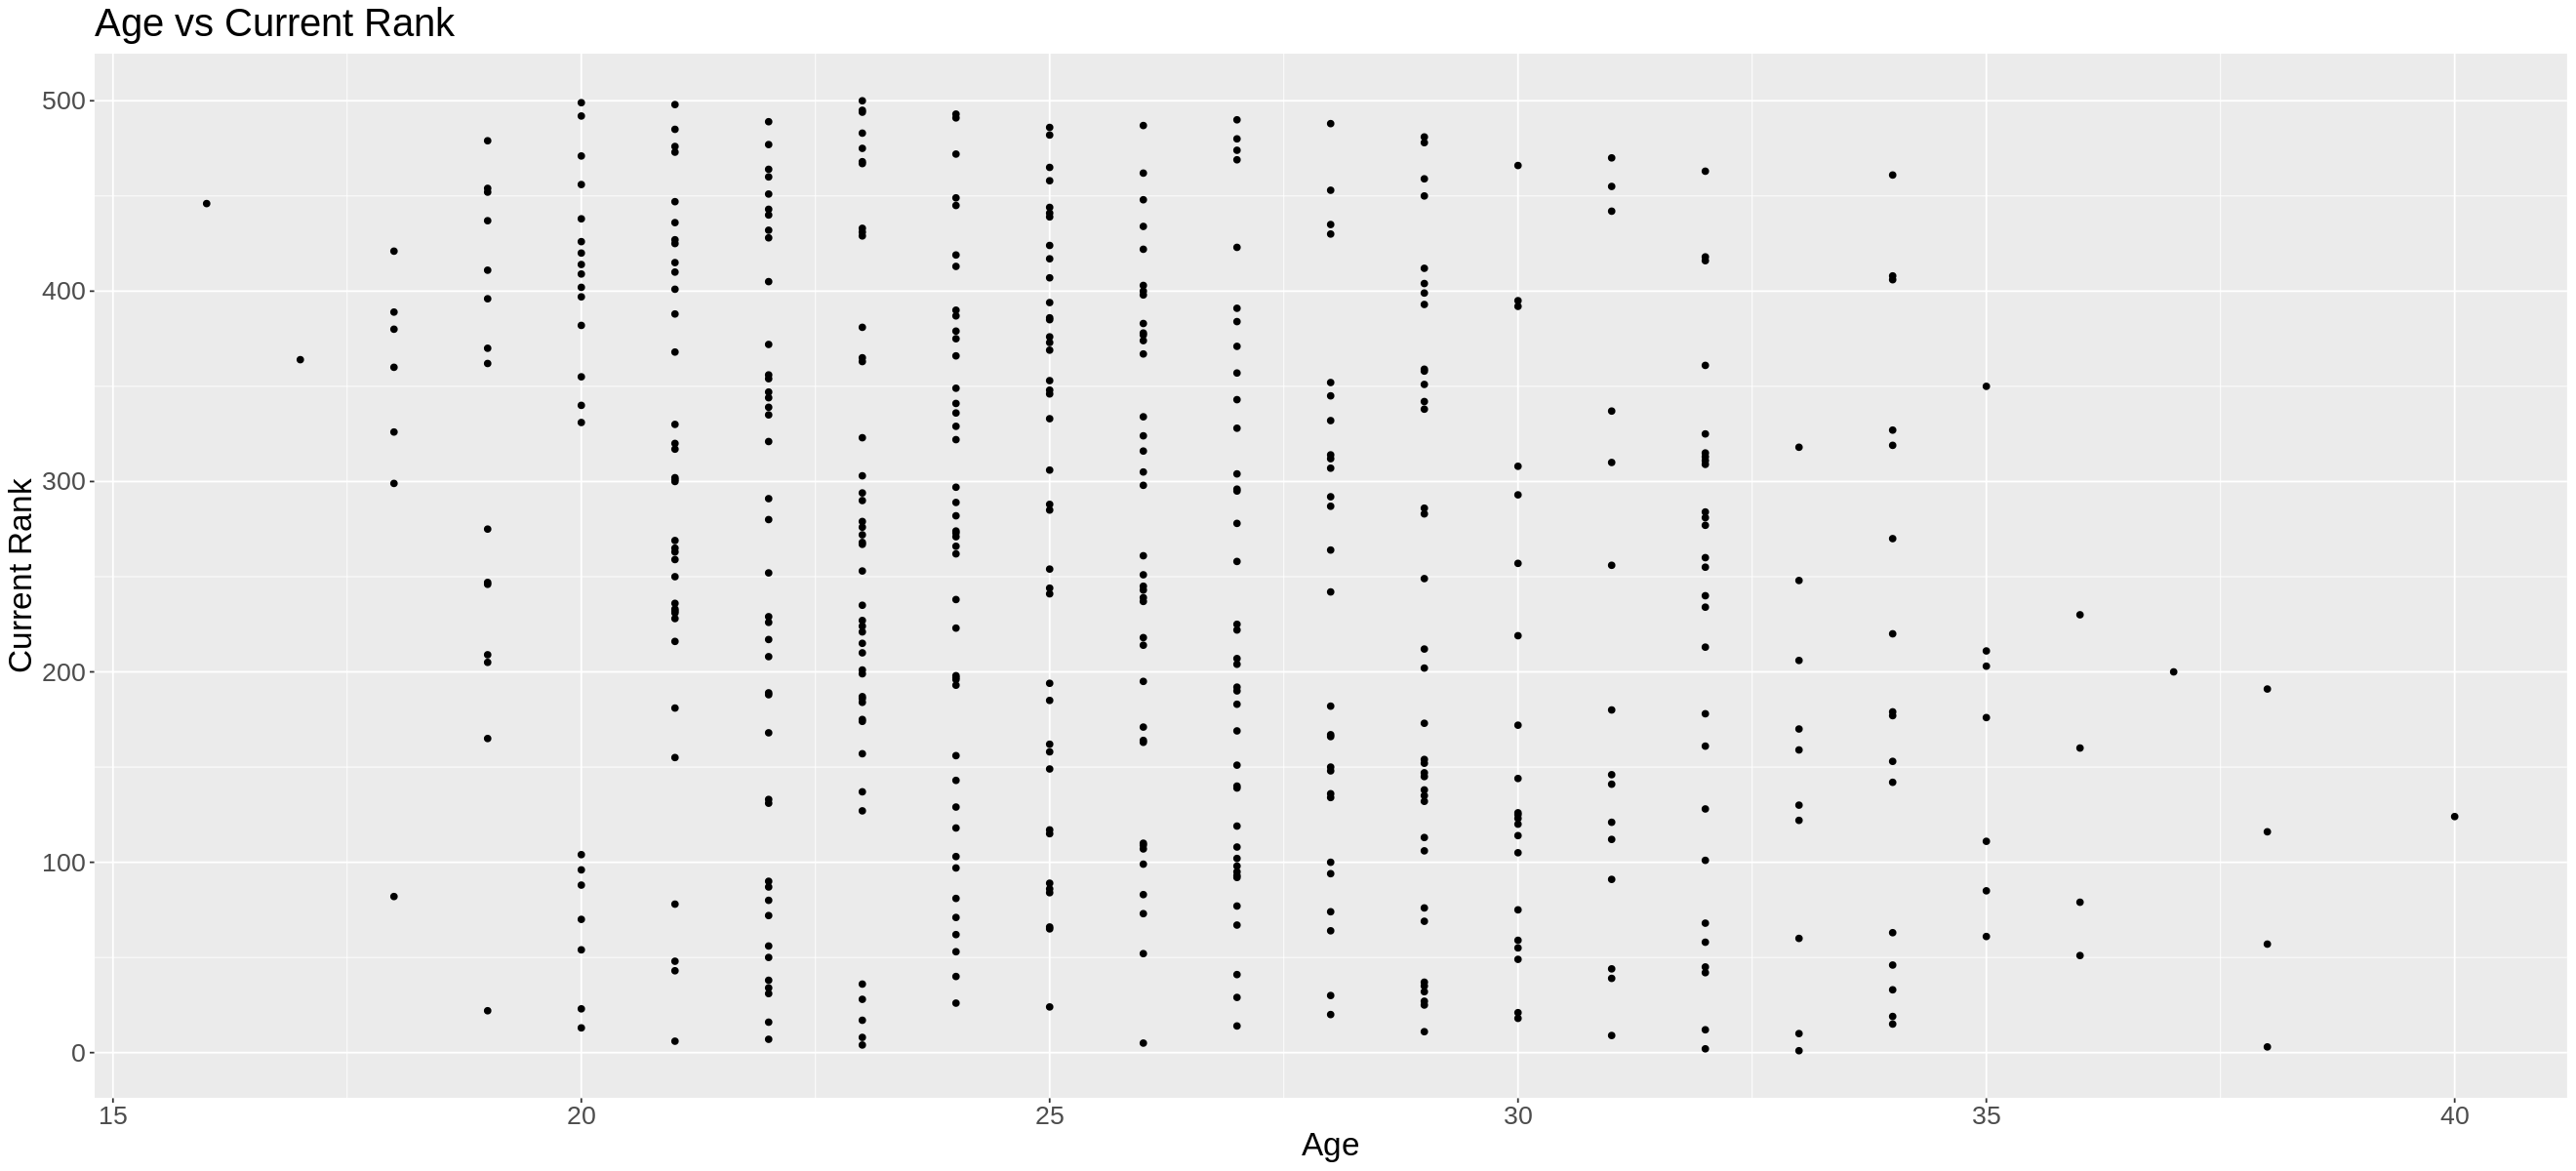

In [38]:
options(repr.plot.width = 22, repr.plot.height = 10)
#best_rank_distribution <- ggplot(tennis_data_tidy, aes(fill = Retired, x = Best_Rank)) +
#                          stat_bin(geom = "bar", position = "stack") +
#                          geom_histogram(stat_bin = "count", binwidth = 10) +
#                          labs(x = "Best Rank", y = "Number of Players") +
#                          theme(text = element_text(size =20)) +
#                          ggtitle("Distribution of Tennis Players Best Rank")
#best_rank_distribution 

#current_rank_vs_age <- ggplot(tennis_data_tidy, aes(fill = Retired, x = Age_at_Best_Rank)) +
#                        geom_histogram(stat_bin = "count", binwidth = 1)+ 
#                        labs(x = "Age at Best Rank", y = "Number of Players") +
#                        theme(text = element_text(size =20)) +
#                        ggtitle("Distribution of Tennis Players Age")
#current_rank_vs_age

player_per_country_distribution <-  tennis_data %>%
                                    head(12) %>%
                                    ggplot( aes(x= Country, y= Players_per_Country)) +
                                    geom_bar(stat= "identity", position = "dodge") +
                                    labs(x = "Country", y = "Players per Country") +
                                    theme(text = element_text(size =20)) +
                                    ggtitle("Countries with the most players")
player_per_country_distribution 
age_vs_best_rank <- tennis_data_tidy %>%
             #       head(100) %>%
                    ggplot(aes( x = Age, y= Current_Rank)) +
                    geom_point() +
                    labs(x = "Age", y = "Current Rank") +
                    theme(text = element_text(size =20)) +
                    ggtitle("Age vs Current Rank")
age_vs_best_rank